## PyXel Example: Constant Model

This example shows how to fit a constant to the sky background level in the direction of the merging galaxy cluster ZwCl 2341.1+0000. The constant model is loaded from `astropy.modeling`. Chandra data is used for the analysis.

Below we import the packages required to run the complete example:

In [16]:
%matplotlib inline
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from astropy.modeling.functional_models import Const1D

In [17]:
from pyxel import Image, load_region
from pyxel.fitters import CstatFitter

There are four Chandra observations of ZwCl 2341.1+0000. The fully processed images in the energy band 0.5-2 keV are available in the `PyXel` GitHub repository. There are three types of images: cluster count images, instrumental background count images, and exposure maps. Point sources have been removed from the exposure maps to differentiate between pixels with no photons and pixels that were unexposed or contaminated with point sources.

Below we read the images and create a surface brightness profile in annuli centered on the cluster. The profile is binned linearly to a minimum of 25 counts/bin. If the profile is unchanged, then it only needs to be created once, rather than every time the code is run. Therefore, we save it in `skybkg.pkl`. If this file exists, then the profile is simply read from it, which is much faster than recreating it.

In [19]:
DATADIR = "../data/"
pkl = "skybkg.pkl"
if os.path.exists(pkl):
    with open(pkl, "rb") as f:
        p = pickle.load(f)
else:
    src_imgs = Image([DATADIR + "srcfree_bin4_500-2000_5786_band1_thresh.img",
                      DATADIR + "srcfree_bin4_500-2000_17170_band1_thresh.img",
                      DATADIR + "srcfree_bin4_500-2000_17490_band1_thresh.img",
                      DATADIR + "srcfree_bin4_500-2000_18702_band1_thresh.img",
                      DATADIR + "srcfree_bin4_500-2000_18703_band1_thresh.img"])
    exp_imgs = Image([DATADIR + "srcfree_bin4_500-2000_5786_band1_thresh.expmap_nosrcedg",
                      DATADIR + "srcfree_bin4_500-2000_17170_band1_thresh.expmap_nosrcedg",
                      DATADIR + "srcfree_bin4_500-2000_17490_band1_thresh.expmap_nosrcedg",
                      DATADIR + "srcfree_bin4_500-2000_18702_band1_thresh.expmap_nosrcedg",
                      DATADIR + "srcfree_bin4_500-2000_18703_band1_thresh.expmap_nosrcedg"])
    bkg_imgs = Image([DATADIR + "5786_bin4_500-2000_bgstow_goodreg.img",
                      DATADIR + "17170_bin4_500-2000_bgstow_goodreg.img",
                      DATADIR + "17490_bin4_500-2000_bgstow_goodreg.img",
                      DATADIR + "18702_bin4_500-2000_bgstow_goodreg.img",
                      DATADIR + "18703_bin4_500-2000_bgstow_goodreg.img"])
    region = load_region(DATADIR + "skybkg.reg")
    p = region.sb_profile(src_imgs, bkg_imgs, exp_imgs, min_counts=25, islog=False)
    with open(pkl, "wb") as f:
        pickle.dump(p, f)

Beyond ~5.6 arcmin, the profile flattens to an approximately constant level. Regions beyond this radius therefore contain only sky background emission. Below we select the profile parameters required by the fit, restricted to the radius range 5.6-9.6 arcmin.

In [11]:
rmin, rmax = 5.6, 9.6

# These are needed to fit the data using C-stat.
r = np.array([pp[0] for pp in p if rmin <= pp[0] <= rmax])
r_err = np.array([pp[1] for pp in p if rmin <= pp[0] <= rmax])
raw_cts = np.array([pp[2] for pp in p if rmin <= pp[0] <= rmax])
bkg_cts = np.array([pp[4] for pp in p if rmin <= pp[0] <= rmax])
t_raw = np.array([pp[11] for pp in p if rmin <= pp[0] <= rmax])
t_bkg = np.array([pp[12] for pp in p if rmin <= pp[0] <= rmax])

# These we load too, so that we can make a pretty figure in the end.
sx = np.array([pp[7] for pp in p if rmin <= pp[0] <= rmax])
sx_err = np.array([pp[8] for pp in p if rmin <= pp[0] <= rmax])
bkg = np.array([pp[9] for pp in p if rmin <= pp[0] <= rmax])
bkg_err = np.array([pp[10] for pp in p if rmin <= pp[0] <= rmax])

We plot the profile to have an estimate for the background level. This estimate will be the guess for our fit.

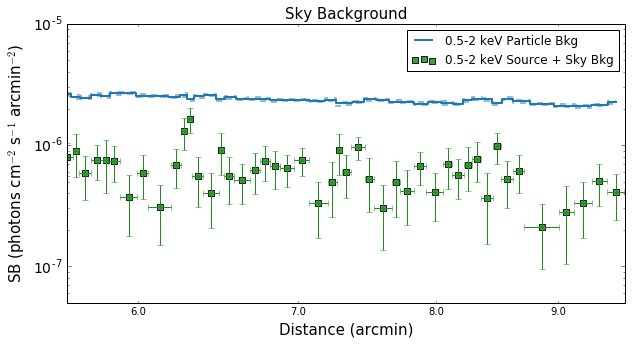

In [20]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(r, sx, c="#1e8f1e", alpha=0.85, s=35, marker="s",
           label="0.5-2 keV Source + Sky Bkg")
ax.errorbar(r, sx, xerr=r_err, yerr=sx_err, linestyle="None", color="#1e8f1e")
ax.step(r, bkg, where="mid", color="#1f77b4", linewidth=2,
        label="0.5-2 keV Particle Bkg")
ax.step(r, bkg - bkg_err, where="mid", color="#1f77b4", linewidth=2, alpha=0.5, linestyle="--")
ax.step(r, bkg + bkg_err, where="mid", color="#1f77b4", linewidth=2, alpha=0.5, linestyle="--")
ax.semilogx()
ax.semilogy()
ax.get_xaxis().set_major_formatter(mtick.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(mtick.ScalarFormatter())
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xlim(rmin, rmax)
plt.ylim(5e-8, 1e-5)
plt.xlabel("Distance (arcmin)", size=15)
plt.ylabel(r"SB (photons cm$^{-2}$ s$^{-1}$ arcmin$^{-2}$)", size=15)
plt.legend(loc=1)
plt.title("Sky Background", size=15)
plt.show()

The sky background level is a bit below 1e-6, so 1e-6 should be a good guess, especially given the simplicity of the model. We fit the data using the extended C-statistic (same as in Xspec).

In [21]:
model = Const1D(amplitude=1e-6)
fit = CstatFitter()
fitted_model = fit(model, r, raw_cts, bkg_cts, t_raw, t_bkg, maxiter=500)
print(fitted_model)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       amplitude    
    ----------------
    5.4518737793e-07


//anaconda/lib/python3.5/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method nelder-mead does not use gradient information (jac).
  RuntimeWarning)
/Users/gogrean/code/pyxel/pyxel/optimizers.py:97: OptimizeWarning: Unknown solver options: eps, factr
  args=fargs, tol=acc, **kwargs)


Uncertainties on the parameters are calculated using MCMC. The uncertainties below are calculated at the 90% confidence level. We save the chain to a file, so that we can simply load it next time (e.g., if the level at which the uncertainties are calculated is changed). To load an existing chain file, suppy the filename to `chain_filename` and set `clobber_chain=False`. MCMC runs can be expensive, especially for complex models (can take up to a few hours when run on two cores in the case of an integrated broken power-law model), so it's generally a very good idea to save the results.




FIT SUMMARY:

| Parameter   |     Value |   Lower Uncertainty |   Upper Uncertainty |
|-------------+-----------+---------------------+---------------------|
| amplitude   | 5.446e-07 |          -3.683e-08 |           3.748e-08 |





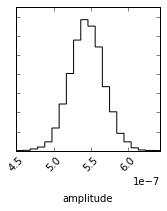

In [22]:
mcmc_err = fit.mcmc_err(fitted_model, r, raw_cts, bkg_cts, t_raw, t_bkg, 
                        cl=90., save_chain=True, clobber_chain=True)

Finally, we plot the best-fitting value from the MCMC run, and the 90% uncertainty band.

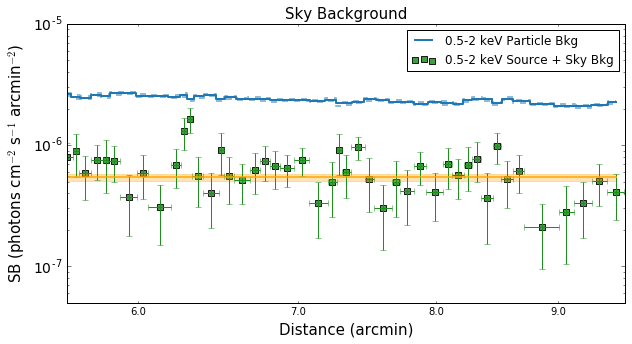

In [23]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(r, sx, c="#1e8f1e", alpha=0.85, s=35, marker="s",
           label="0.5-2 keV Source + Sky Bkg")
ax.errorbar(r, sx, xerr=r_err, yerr=sx_err, linestyle="None", color="#1e8f1e")
ax.step(r, bkg, where="mid", color="#1f77b4", linewidth=2,
        label="0.5-2 keV Particle Bkg")
ax.step(r, bkg - bkg_err, where="mid", color="#1f77b4", linewidth=2, alpha=0.5, linestyle="--")
ax.step(r, bkg + bkg_err, where="mid", color="#1f77b4", linewidth=2, alpha=0.5, linestyle="--")

ax.plot(r, fitted_model(r), color="#ffa500", linewidth=2, alpha=0.75)
ax.fill_between(r, mcmc_err[0][1] + mcmc_err[0][2], mcmc_err[0][1] + mcmc_err[0][3], alpha=0.3, color="#ffa500")

ax.semilogx()
ax.semilogy()
ax.get_xaxis().set_major_formatter(mtick.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(mtick.ScalarFormatter())
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xlim(rmin, rmax)
plt.ylim(5e-8, 1e-5)
plt.xlabel("Distance (arcmin)", size=15)
plt.ylabel(r"SB (photons cm$^{-2}$ s$^{-1}$ arcmin$^{-2}$)", size=15)
plt.legend(loc=1)
plt.title("Sky Background", size=15)
plt.show()